In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image, ImageDraw
from random import randint
import json

Create pillow images to maniupulate in order to fabricate training data. This synthetic training data will be used to train the models responsible for reading the value from each sensor in real time.

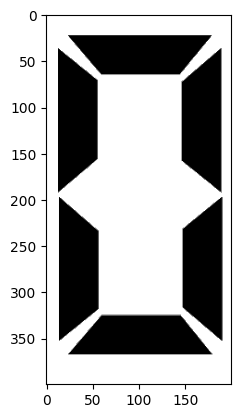

In [4]:
source_digits = {"0": Image.open("training/MASTER/hq_0.png"),
                 "1": Image.open("training/MASTER/hq_1.png"),
                 "2": Image.open("training/MASTER/hq_2.png"),
                 "3": Image.open("training/MASTER/hq_3.png"),
                 "4": Image.open("training/MASTER/hq_4.png"),
                 "5": Image.open("training/MASTER/hq_5.png"),
                 "6": Image.open("training/MASTER/hq_6.png"),
                 "7": Image.open("training/MASTER/hq_7.png"),
                 "8": Image.open("training/MASTER/hq_8.png"),
                 "9": Image.open("training/MASTER/hq_9.png")}

bionare_sensor_background = Image.open("training/MASTER/bionare_background.png")

plt.imshow(source_digits["0"])
plt.show()

Creates a pillow image with an appropriate background to match the sensor image closely, it is also resized and rotated according to a certain pose.json file which specifies: for each image, where to place the synthic digits image, how to rotate it, and what background best suites this paste operation.

In [5]:
def create_digits_image(target_int, target_width, target_height, target_rotation, background):
    segments = list(str(target_int))

    width = 0
    height = 0
    for segment in segments:
        w, h = source_digits[segment].size
        width += w
        height = max(height, h)

    canvas = Image.new("RGB", (width, height))
    canvas.paste(background, (0,0))
    
    x_shift = 0
    for digit in segments:
        img = source_digits[digit]
        canvas.paste(img, (x_shift,0), img.convert("RGBA"))
        x_shift += img.width


    canvas = canvas.convert("RGBA").rotate(target_rotation, expand=True)
    canvas = canvas.resize((target_width, target_height), Image.Resampling.LANCZOS)
    canvas.convert("RGBA")

    return canvas

create_digits_image(12, 50,  25, 10, bionare_sensor_background)

Test Creation of a training example for the particular humidity sensor I am using. A grey bionare humidity and temperature device. Note: to reduce differences between synthic and real training example, there will be thresholding operations applied to each training image. The original image has 39% humidity in the top row.

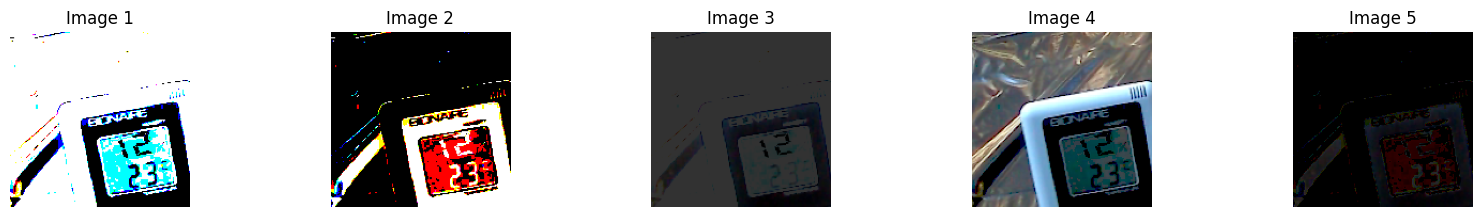

In [6]:
def generate_humidity_training(target_int):
    
    path = "training/HumiditySensor/backgrounds"
    backgrounds = os.listdir(path)
    background = backgrounds[randint(0, len(backgrounds)-1)]
    source_image = Image.open(f"{path}/{background}/img.png")
    with open(f"{path}/{background}/pose.json", "r") as fh:
        pose = json.load(fh)
    
    x, y = pose["x"], pose["y"]
    target_rotation = pose["rotate"]

    digits = create_digits_image(target_int, 40, 25, target_rotation, bionare_sensor_background)
    digits = digits.rotate(target_rotation)
    source_image.paste(digits, (x, y), digits)

    # source_image.save(f"training/HumiditySensor/outputs/{target_int}.png")

    img = np.array(source_image)
    blurred = cv2.GaussianBlur(img, (7, 7), 2)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

    rtn, t1 = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    rtn, t2 = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY_INV)
    rtn, t3 = cv2.threshold(img, 50, 255, cv2.THRESH_TRUNC)
    rtn, t4 = cv2.threshold(img, 50, 255, cv2.THRESH_TOZERO)
    rtn, t5 = cv2.threshold(img, 50, 255, cv2.THRESH_TOZERO_INV)

    display = [t1, t2, t3, t4, t5]

    rows = 2
    columns = len(display)
    fig = plt.figure(figsize=(20,5))
    for i in range(len(display)):
        frame = display[i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(frame)
        plt.axis("off")
        plt.title(f"Image {i+1}")

    plt.show()
generate_humidity_training(12)

In [7]:
def generate_ambient_temp_training(target_int):
    pass

In [8]:
def generate_weight_training(target_int):
    pass

By sligthly rotating, and manipulating a single trainig it can be used effectively many times over. Therefore this functionality reads an already label example, and maniulates into multiple other examples under the same label.

(168, 164)
(168, 164)
(168, 164)
(168, 164)
(168, 164)
(168, 164)
(168, 164)
(168, 164)
(168, 164)


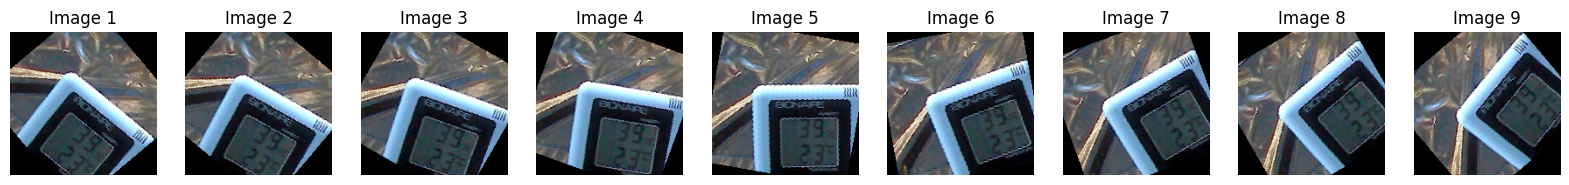

In [21]:
def generate_regression_duplicates(target_file):

    source_image = Image.open(f"{target_file}")

    positive_range = 50
    negative_range = -50
    step = 10

    rotated_images = []

    for degree in range(negative_range, positive_range, step):
        if degree != 0:
            rotated_images.append(source_image.rotate(degree))

    return rotated_images

ar = generate_regression_duplicates("training/HumiditySensor/backgrounds/1/img.png")

rows = 2
columns = len(ar)
fig = plt.figure(figsize=(20,5))
for i in range(len(ar)):
    frame = ar[i]
    print(frame.size)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(frame)
    plt.axis("off")
    plt.title(f"Image {i+1}")

